### MNIST handwritten digits dataset for image classification

In this example we will utilize the functionalitis of pytorch for data loading and rnn models.

The task will be image classification on MNIST dataset utilizing sequence models.


Modified example from [here](https://www.dezyre.com/recipes/run-basic-rnn-model-using-pytorch)

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys



def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

device = 'cpu'
print('Working on:', device)

Working on: cpu


In [2]:
# How many images at once
BATCH_SIZE = 64

# Mnist digital dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,
    # Converts a PIL.Image or numpy.ndarray to torch.FloatTensor of shape (Channel x Height x Width) and normalize in the range [0.0, 1.0]
    transform=transforms.ToTensor(),    
    # Set to True for the first time to download it                        
    download=False,            
)

# Data Loader for batching
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE, shuffle=True)

torch.Size([60000, 28, 28])
torch.Size([60000])


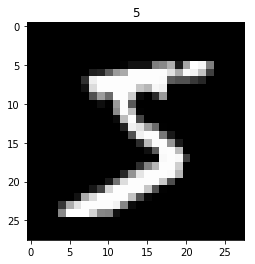

In [3]:
# plot one example
print(train_data.data.size())     # (60000, 28, 28)
print(train_data.targets.size())   # (60000)
plt.imshow(train_data.data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

In [4]:
# Get a subset of the test set for fast evaluation
TEST_SIZE = 1000
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=TEST_SIZE, shuffle=True)
# Remove the channel dimension
for step, (test_x, test_y) in enumerate(test_loader):
    test_x = test_x.view(-1,28,28)
    pass
print(test_x.shape, test_y.shape)

torch.Size([1000, 28, 28]) torch.Size([1000])


#### Question:
    - How can we view this image a sequence?
    - What type of tasks is this? N-to-N? 

<img src="./mnist_lstm.png" width="800">

In [5]:
class RNN(nn.Module):
    """
    Wrapper module for RNN, LSTM, GRU cells using pytorch api. The output is fed to a FFN for classification.
    """
    def __init__(self, cell_type, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        cells = {
        "RNN" : nn.RNN,
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU
    }
        self.cell_type = cell_type
        self.rnn = cells[cell_type](         # Pick the specific model
            input_size=input_size,           # Number of features for each time step
            hidden_size=hidden_size,         # rnn hidden units
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(hidden_size, output_size) # Feed forward network

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x) 
        else:
            r_out, h_n = self.rnn(x)

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

In [6]:
input_size = 28
hidden_size = 64
output_size = 10
cell_type = 'LSTM'
net = RNN(cell_type, input_size, hidden_size, output_size)
print(net)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


#### Question:
 - What are the output dimensions?
 - What are other strategies for getting the representation of the whole image as input to the last-layer FFN?

In [7]:
EPOCH = 1
LR = 0.01

optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all net parameters
loss_func = nn.CrossEntropyLoss()     

Epoch:  0 | train loss: 2.3094 | test accuracy: 0.11
Epoch:  0 | train loss: 1.1737 | test accuracy: 0.65
Epoch:  0 | train loss: 0.5995 | test accuracy: 0.77
Epoch:  0 | train loss: 0.2556 | test accuracy: 0.81
Epoch:  0 | train loss: 0.5036 | test accuracy: 0.88
Epoch:  0 | train loss: 0.4031 | test accuracy: 0.93
Epoch:  0 | train loss: 0.3027 | test accuracy: 0.93
Epoch:  0 | train loss: 0.3472 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2327 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1547 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1181 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1763 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2232 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1304 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1873 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0550 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0975 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1681 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0577 | test accuracy

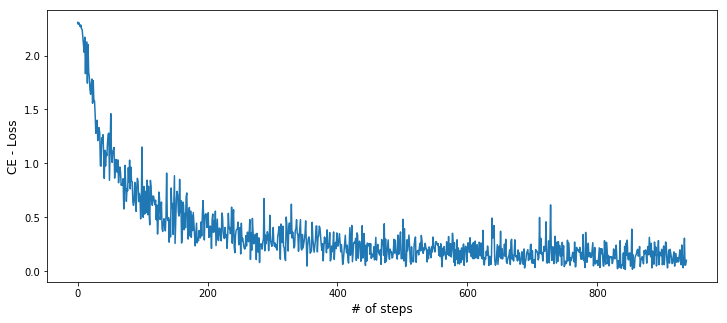

In [8]:
# training and testing

# Start train mode
net.train()
# Accumulate losses
losses = []
# Count the number of batches given to the model
step_count = 0
# Evaluate the progress every # batches
print_every = 50

# Iterate over the whole dataset for one epoch
for epoch in range(EPOCH):
    # Generate batch data
    for step, (x, y) in enumerate(train_loader):
        # clear gradients for this training step
        optimizer.zero_grad() 
        
        # reshape x to (batch, time_step, input_size)
        b_x = x.view(-1, 28, 28)
        # batch y
        b_y = y                               
        
        
        output = net(b_x)                               
        loss = loss_func(output, b_y) 
        
        # For visualization
        losses.append(loss.item())
        step_count += 1
        
        
        # backpropagation - compute gradients                             
        loss.backward() 
        # apply gradients
        optimizer.step()                               
    
        # evaluate every N batches
        if step % print_every == 0:
            # Do not calculate gradients
            with torch.no_grad():
                # Faster inference
                net.eval()
                
                test_output = net(test_x)
                # Get predicted class
                pred_y = torch.argmax(test_output, dim=1).squeeze()
                # Calculate accuracy
                accuracy = (pred_y == test_y).sum().item() / float(TEST_SIZE)
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)
            # Return to training mode
            net.train()

# Plot results
plt.figure(figsize=(12,5))
plt.plot(losses)
plt.xlabel('# of steps', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()

## Questions:
- Try playin around with models/lr/epochs/hidden_size (e.g. RNN, 0.001) and guess the behavior

## Inference on a set of samples

In [9]:
N = 10
print(f'Make: {N} predictions')
test_output = net(test_x[:N,:,:].view(-1,28,28))
y_pred = torch.argmax(test_output, dim=1).data.numpy().squeeze()
y_true = test_y[:N].data.numpy().squeeze()
print(y_true, 'real number')
print(y_pred, 'prediction number')

Make: 10 predictions
[4 9 2 4 9 7 1 1 2 1] real number
[4 9 2 4 9 7 1 1 2 1] prediction number


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
print(f'Classification Report:')
print(f'{classification_report(y_true, y_pred)}')
print(f'Confusion Matrix')
print(confusion_matrix(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Confusion Matrix
[[3 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 1 0]
 [0 0 0 0 2]]


## Other details:

- Bidirectional + Multilayer. Check out layer sizes from the docs e.g. [LSTM module](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
- Skipping connections
- Trainable/Frozen embeddings as input
- Hyperparameter tuning in pytorch
